# Pancreas Advanced

This tutorial shows how to work with CellRank using the **low-level mode**. We will interact directly with CellRank's two main modules, [kernels](https://cellrank.readthedocs.io/en/latest/classes.html#kernels) and [estimators](https://cellrank.readthedocs.io/en/latest/classes.html#estimators). We assume that you have gone through the [high level tutorial](https://cellrank.readthedocs.io/en/latest/pancreas_basic.html) already.

The first part of this tutorial is very similar to [scVelo's tutorial on pancreatic endocrinogenesis](https://scvelo-notebooks.readthedocs.io/Pancreas.html). This is essentially the same as in the high level tutorial, so feel free to skip the beginning and go directly to the section [Run CellRank](#Run-CellRank). The data we use here comes from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). For more info on scVelo, see the [documentation](https://scvelo-notebooks.readthedocs.io/index.html) or read the [preprint](https://www.biorxiv.org/content/10.1101/820936v1). 


This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/pancreas_advanced.ipynb).

## Import packages & data

Easiest way to start is to download [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) along with the environment file found [here](https://raw.githubusercontent.com/theislab/cellrank_notebooks/master/environment.yml). To create the environment, run `conda create -f environment.yml`.

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

First, we need to get the data. The following commands will download the `adata` object and save it under `datasets/endocrinogenesis_day15.5.h5ad`.

In [2]:
adata = cr.datasets.pancreas()
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.81 0.19]


AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:03)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. The first step, estimating the parameters of the dynamical model,  may take a while (~10min). To make sure we only have to run this once, we developed a caching extension called [scachepy](https://github.com/theislab/scachepy). scachepy does not only work for `recover_dynamics`, but it can cache the output of almost any scanpy or scvelo function. To install it, simply run 

```
pip install git+https://github.com/theislab/scachepy
```

If you don't want to install scachepy now, don't worry, the below cell will run without it as well and this is the only place in this tutorial where we're using it. 

In [4]:
try:
    import scachepy
    c = scachepy.Cache('../../cached_files/basic_tutorial/')
    c.tl.recover_dynamics(adata, force=False)
except ModuleNotFoundError:
    print("You don't seem to have scachepy installed, but that's fine, you just have to be a bit patient (~10min). ")
    scv.tl.recover_dynamics(adata)

You don't seem to have scachepy installed, but that's fine, you just have to be a bit patient (~10min). 
recovering dynamics
    finished (0:11:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the velocities and the velocity graph. The velocity graph is a weighted graph that specifies how likely two cells are to transition into another, given their velocity vectors and relative positions. 

In [5]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


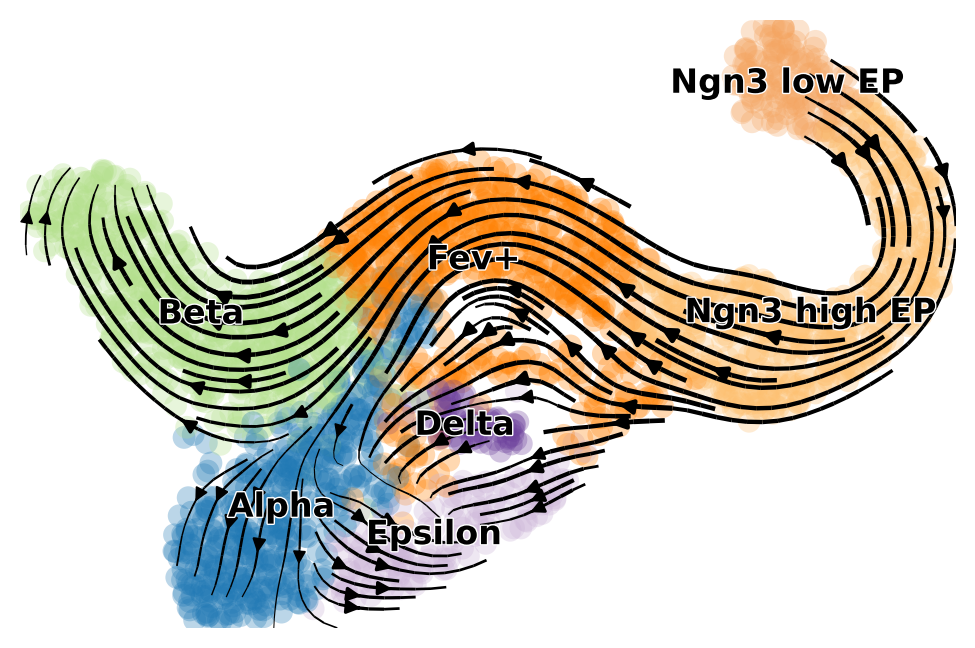

In [6]:
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)

## Run CellRank

CellRank is a package for analyzing directed single cell data, whereby we mean single cell data that can be respresented via a directed graph. Most prominently, this is the case for single cell data where velocities have been computed - we can use these to direct the KNN graph. However, there are other situations in which we can inform the KNN graph of the direciton of the process, using i.e. pseudotime (see [Palantir](https://doi.org/10.1038/s41587-019-0068-4)) or information obtained via mRNA labeling with e.g. [scSLAM-seq](https://doi.org/10.1038/s41586-019-1369-y), [scEU-seq](https://doi.org/10.1126/science.aax3072) or [sci-fate](https://doi.org/10.1038/s41587-020-0480-9). Because we wanted CellRank to be widely applicable, no matter how directionality was introduced to the data, we split it up into two main modules, `kernels` and `estimators`. In short, `kernels` allow you to compute a (directed) transition matrix, whereas `estimators` allow you to analyze it.

## Kernels

To construct a transition matrix, CellRank offers a number of kernel classes in `cellrank.tl.kernels`. Currently implemented are the following:

 - `VelocityKernel`: compute transition matrix based on RNA velocity.
 - `ConnectivityKernel`: compute symmetric transition matrix based on transcriptomic similarity (essentially a [DPT](https://doi.org/10.1038/nmeth.3971) kernel).
 - `PalantirKernel`: mimics [Palantir](https://doi.org/10.1038/s41587-019-0068-4).
 
These kernels can be combined by simply using the `+` or `*` operator, we will demonstrate this below. To find out more, check out the [API](https://cellrank.readthedocs.io/en/latest/api.html#kernels). Note that the `kernel` classes are designed to be easy to extend to incoporate future kernels based on e.g. mRNA labeling or other sources of directionality. Let's start with the `VelocityKernel`:

In [7]:
from cellrank.tl.kernels import VelocityKernel
vk = VelocityKernel(adata)

To lern more about this object, we can print it:

In [8]:
print(vk)

<Velo>


There is not very much there yet. We can change this by computing the transition matrix:

In [9]:
vk.compute_transition_matrix()

Computing transition matrix based on velocity correlations using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode

Setting `softmax_scale=3.7951`

    Finish (0:00:07)


<Velo>

To see how exactly this transition matrix was computed, we can print the kernel again:

In [10]:
print(vk)

<Velo[softmax_scale=3.8, mode=deterministic, seed=44219]>


There's a lot more info now! To find out what all of these mean, check the docstring of `.compute_transition_matrix`. The most important bits of information here are
 - `mode='deterministic`: by default, the computation is deterministic, but we can also sample from the velocity distribution (`mode='sampling'`), get a 2nd order estimate (`mode='stochastic'`) or a Monte Carlo estimate (`mode='monte_carlo'`).

 - `backward=False`: run the process in the forward direction. To change this, set `backward=True` when initializing the `VelocityKernel`
 - `softmax_scale`: scaling factor used in the softmax to transform cosine similarities into probabilities. The larger this value, the more centered the distribution will be around the most likely cell. If `None`, use velocity variances to scale the softmax, i.e. an automatic way to tune it in terms of local variance in velocities. This requires one additional run (always in 'deterministic' mode, to quickly estimate the scale).

The velocity kernel we computed above would allow us to reproduce the results from the [high level tutorial](https://cellrank.readthedocs.io/en/latest/pancreas_basic.html). However, for the sake of demonstration, let's suppose that our velocities are very noisy and we want to make the analysis more robust by combining the velocity kernel with a connectivity kernel. This is very easy:

In [11]:
from cellrank.tl.kernels import ConnectivityKernel
ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on connectivities
    Finish (0:00:00)


Note how it's possible to call the `.compute_transition_matrix` method direcly when initializing the kernel - this works for all kernel classes. Given these two kernels now, we can combine them:

In [12]:
combined_kernel = 0.8 * vk + 0.2 * ck

Let's print the `combined_kernel` to see what happened:

In [13]:
print(combined_kernel)

((0.8 * <Velo[softmax_scale=3.8, mode=deterministic, seed=44219]>) + (0.2 * <Conn[dnorm=True]>))


There we go, we took the two computed transition matrices stored in the kernel object and combined them using a weighted mean, with weights given by the factors we provided. We will use the `combined_kernel` in the `estimators` section below. 

Before moving on to the `estimators`, let's demonstrate how to set up a `PalantirKernel`. For this, we need a pseudotemporal ordering of the cells. Any pseudotime method can be used here. Note that this won't exactly reproduce the original palantir implementation becasue it uses a specific representation of the data and a specific pseudotime. We will simply use DPT here:

In [14]:
root_idx = np.where(adata.obs['clusters'] == 'Ngn3 low EP')[0][0]
adata.uns['iroot'] = root_idx
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99748987 0.9902442  0.9816529  0.9754233  0.96905994
     0.9629265  0.956972   0.94059503 0.9212148  0.9155121  0.8986904
     0.8907604  0.8846064  0.8736002 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


Note that we did not use the above `VelocityKernel` to infer the initial state here as we assume that in a situation where you want to apply Palantir, you probably don't have acess to velocities!

The last step is to initialize the `PalantirKernel` based on the `adata` object and the pre-computed diffusion pseudotime. If you want to use another pseudotime, use the `time_key` keyword. 

In [15]:
from cellrank.tl.kernels import PalantirKernel
pk = PalantirKernel(adata, time_key='dpt_pseudotime').compute_transition_matrix()
print(pk)

Computing transition matrix based on Palantir-like kernel
    Finish (0:00:01)
<Pala[k=3, dnorm=True, n_neighs=30]>


## Estimators

Estimators take a `kernel` object and offer methods to analyze it. The main objective is to decompose the state space into a set of metastable states (also called macrostates) that represent the slow-time scale dynamics of the process. A subset of these metastable states will be the initial or terminal states of the process, the remaining states will be intermediate transient states. CellRank currently offers two estimator classes in `cellrank.tl.estimators`:

 - `CFLARE`: **C**lustering and **F**iltering **L**eft **A**nd **R**ight **E**igenvectors. Heuristic method based on the spectrum of the transition matrix.
 - `GPCCA`: **G**eneralized **P**erron **C**luster **C**luster **A**nalysis: project the Markov chain onto a small set of macrostates using a Galerkin projection which maximizes the self-transition probability for the macrostates, see [Reuter et al. (2018)](https://doi.org/10.1021/acs.jctc.8b00079). 
 
For more information on the estimators, have a look at the [API](https://cellrank.readthedocs.io/en/latest/api.html#estimators). We will demonstrate the `GPCCA` estimator here, however, the `CFLARE` estimator has a similar set of methods (which do different things internally). Let's start by initializing a `GPCCA` object based on the `combined_kernel` we constructed above:

In [16]:
from cellrank.tl.estimators import GPCCA
g = GPCCA(combined_kernel)
print(g)

GPCCA[n=2531, kernel=((0.8 * <Velo[softmax_scale=3.8, mode=deterministic, seed=44219]>) + (0.2 * <Conn[dnorm=True]>))]


Additionaly to the information about the kernel it is based on, this prints out the number of states in the underlying Markov chain. GPCCA needs a real sorted [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition) to work with, so let's start by computing this and visualizing eigenvalues in complex plane:

Computing Schur decomposition
When computing metastable states, choose a number of states NOT in `[6, 10, 13, 16, 19]`
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)


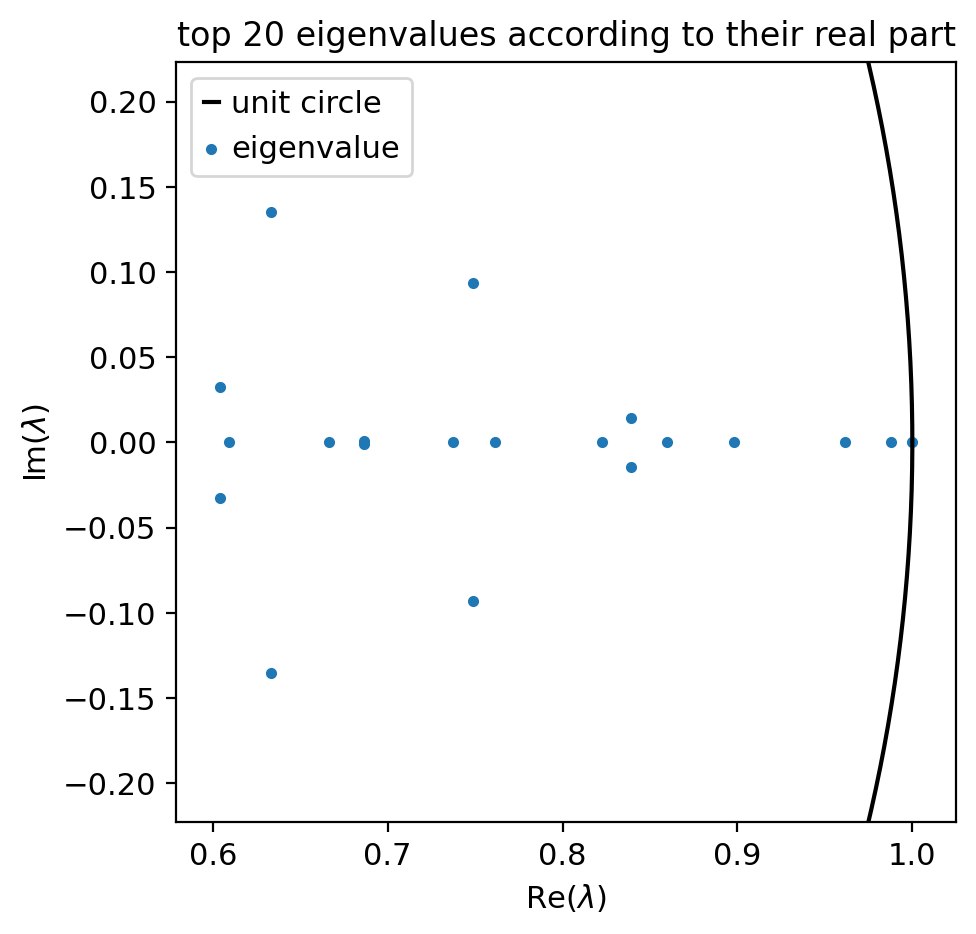

In [17]:
g.compute_schur(n_components=20)
g.plot_spectrum()

To compute the Schur decomposition, there are two methods implemented

 - `method='brandts'`: use `scipy.linalg.schur` to compute a full real Schur decomposition and sort it using a python implementation of [Brandts (2002)](https://doi.org/10.1002/nla.274). Note that `scipy.linalg.schur` only supports dense matrices, so consider using this for small cell numbers (<10k).
 - `method='krylov'`: use an interative, krylov-subspace based algorightm provided in [SLEPc](https://slepc.upv.es/) to directly compute a partial, sorted, real Schur decomposition. This works with sparse matrices and will scale to extremly large cell numbers. 
 
The real Schur decomposition for transition matrix `T` is given by `Q U Q**(-1)`, where `Q` is orthogonal and `U` is quasi-upper triangular, which means it's upper triangular except for 2x2 blocks on the diagonal. 1x1 blocks on the diagonal represent real eigenvalues, 2x2 blocks on the diagonal represent complex eigenvalues. Above, we plotted the top 20 eigenvalues of the matrix `T` to see whether there is an apparent _eigengap_. In the present case, there seems to be such a gap after the first 3 eigenvalues. We can visualize the corresponding Schur vectors in the embedding: 

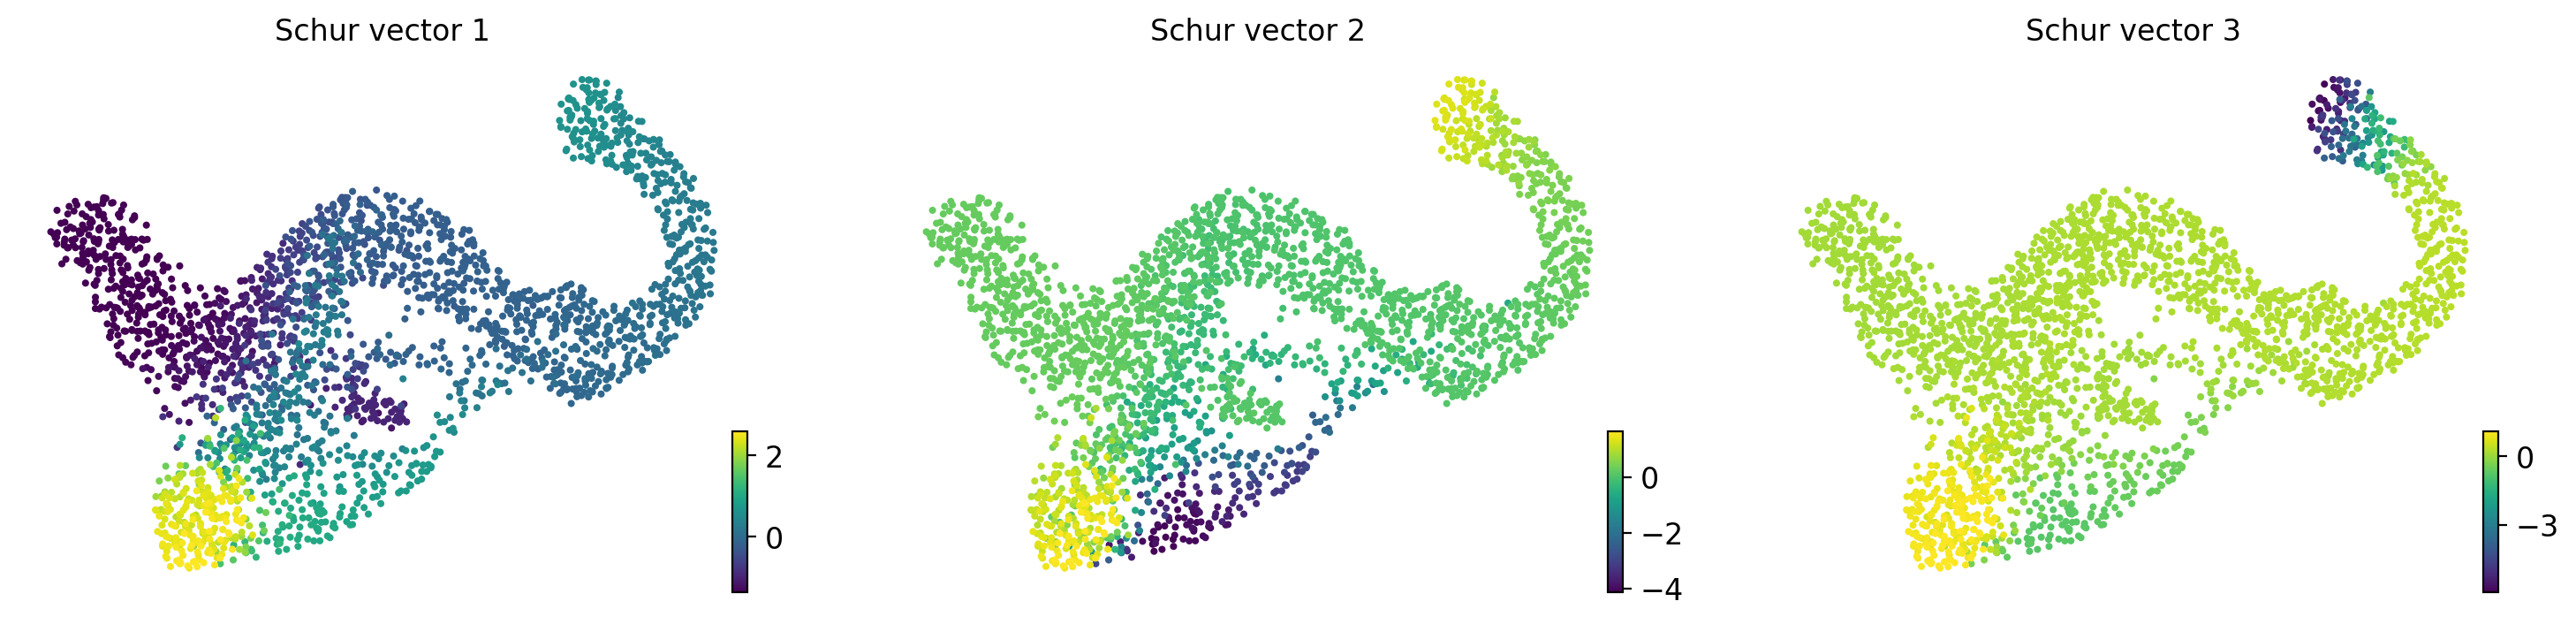

In [18]:
g.plot_schur(use=3)

These vectors will span an invariant subspace, let's call it `X` (Schur vectors in the columns). The next step in `GPCCA` is to find a linear combination of these vectors such that the Markov chain defined on the subset of states has large selt-transition probability. We do this by calling the following method:

Computing metastable states
INFO: Using pre-computed schur decomposition
Adding `.metastable_states_probabilities`
       `.metastable_states`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)


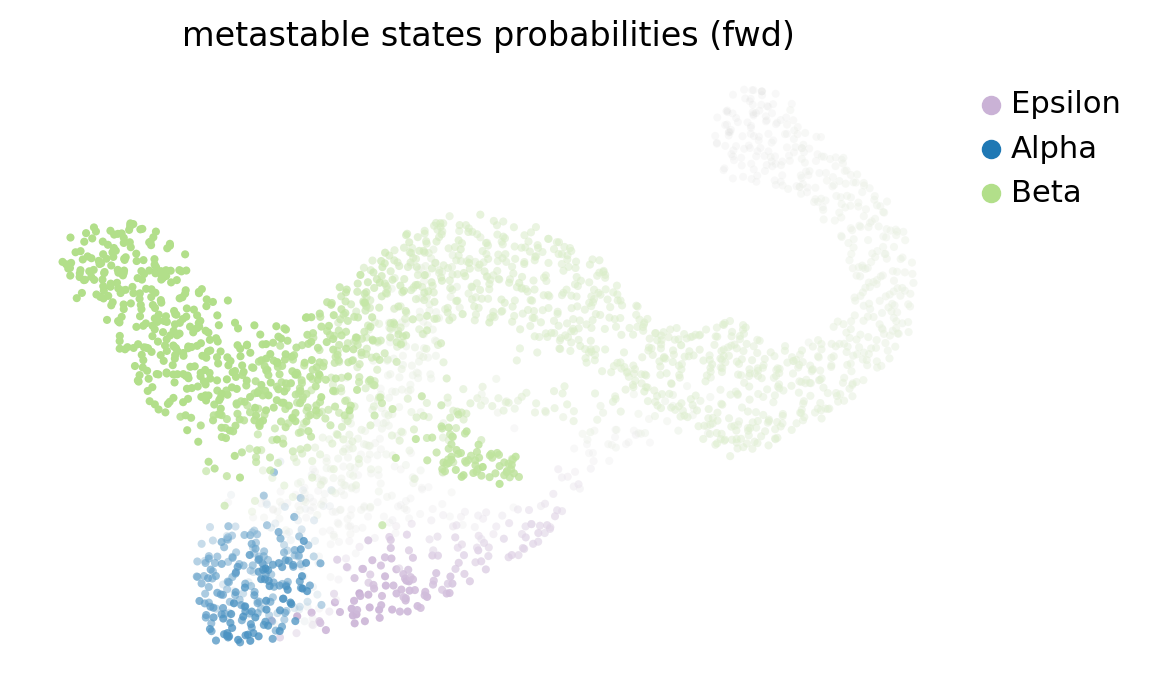

In [19]:
g.compute_metastable_states(n_states=3, cluster_key='clusters')
g.plot_metastable_states()

We can look at individual states by passing `same_plot=False`:

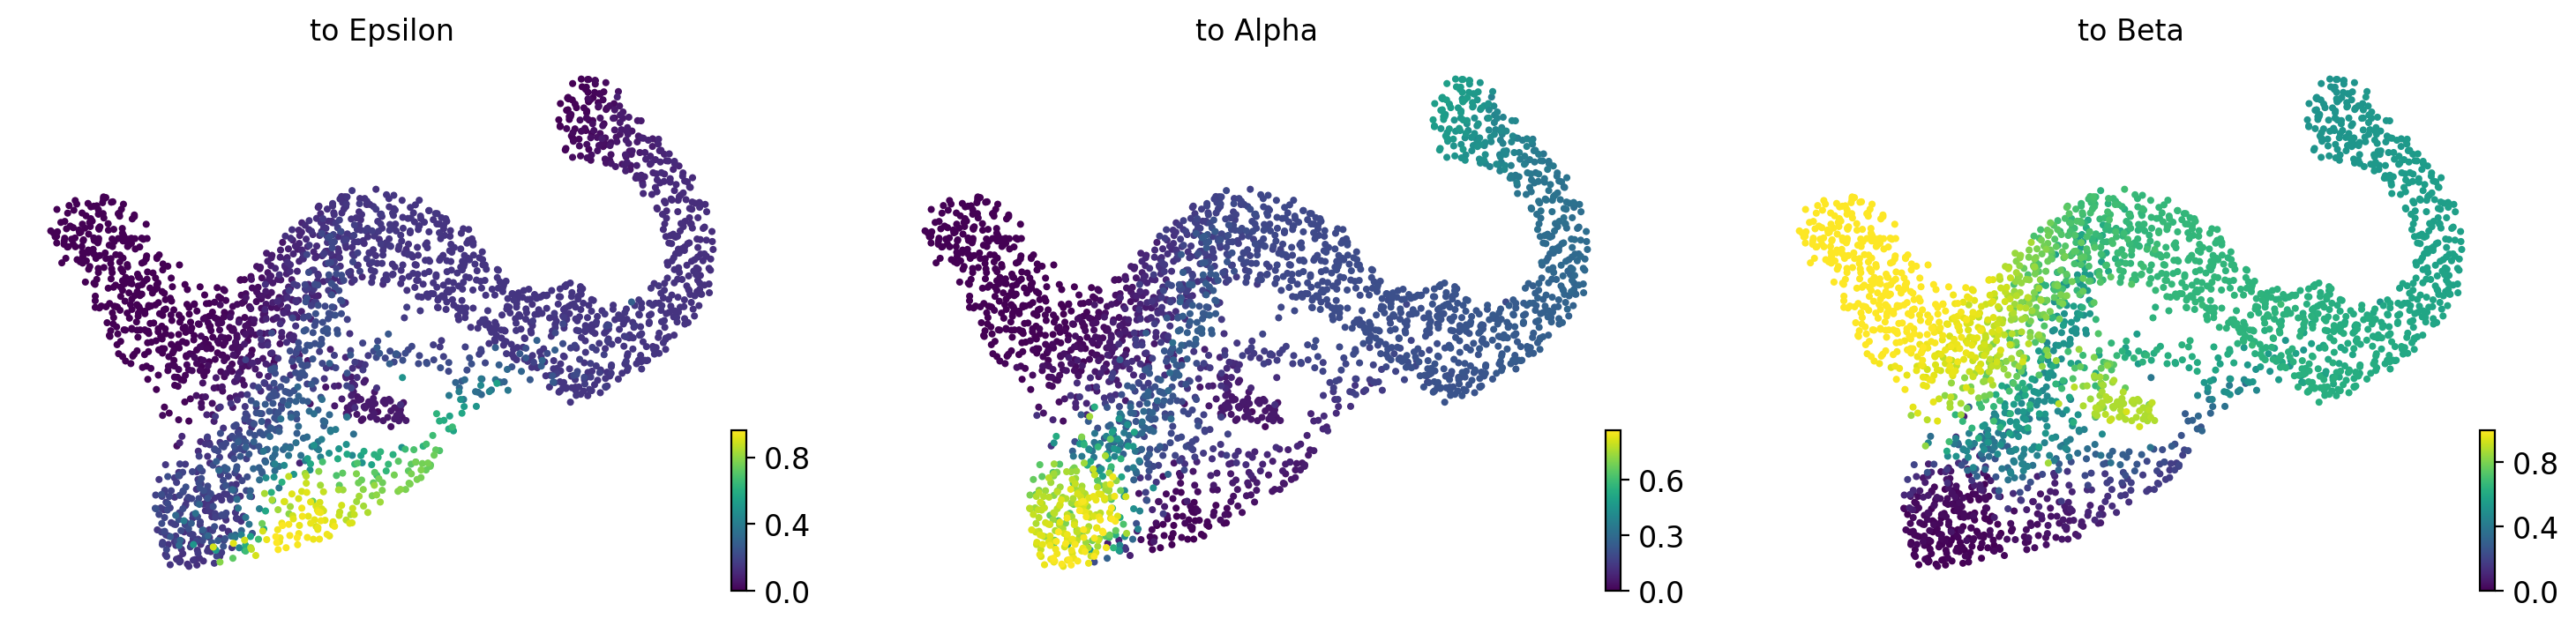

In [20]:
g.plot_metastable_states(same_plot=False)

To see the most likely cells for each of the states, set `discrete=True`. This uses top `n` cells from each lineage, where `n` can be set in `compute_metastable_states` (defaults to 30 cells).

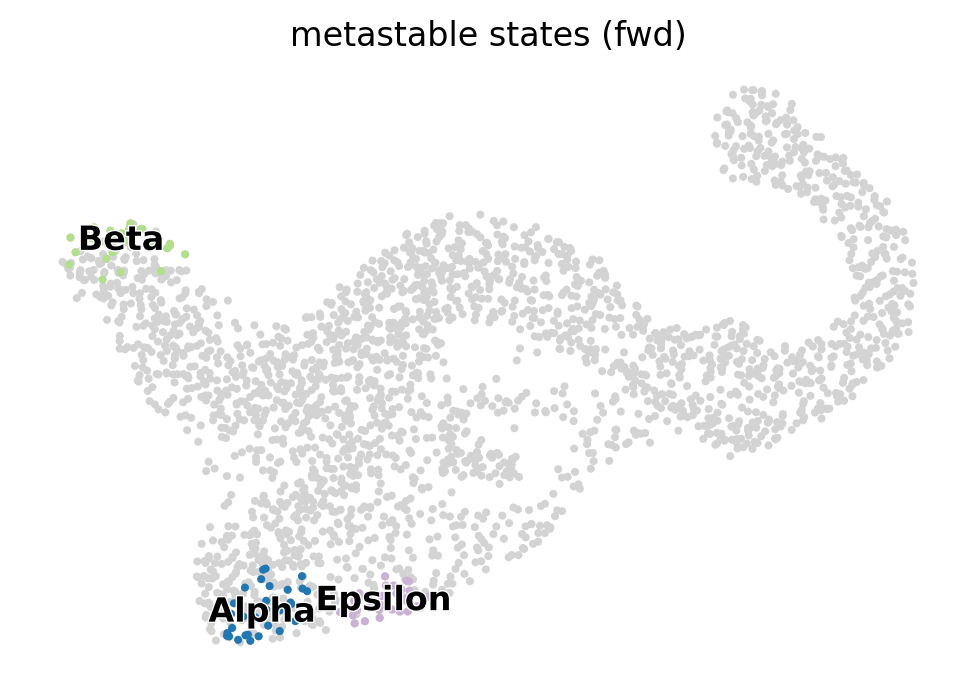

In [21]:
g.plot_metastable_states(discrete=True)

So far, we haven't written anything to `adata` yet. This happens with the following call:

In [22]:
g.set_final_states_from_metastable_states()

Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['metastable_states_fwd']`
       `.final_states_probabilities`
       `.final_states`


Calling `.set_final_states_from_metastable_states` is essentially a restriction of the set of metastable states to a set of main states, which could be initial or terminal states, depending on the direction of the process. 

The method `.set_final_states_from_metastable_states` has a parameter `names` which allows you to pass a list of names like `['Alpha', 'Beta', 'Epsilon']`, which is handy in a situations where you have computed several metastable states, but only a subset of them represents your final states. Using the `names`, you can also combine several metastable states, see the [API](https://cellrank.readthedocs.io/en/latest/classes.html#cellrank.tl.estimators.GPCCA).

After setting our final states, we can compute absorption probabilities towards them as:

In [23]:
g.compute_absorption_probabilities()

Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `adata.obs['to_terminal_states_dp']`
       `.absorption_probabilities`
       `.diff_potential`
    Finish (0:00:00)


Once we have set the `absorption_probabilities`, we can correlate them against all genes to find potential lineage drivers. Below, we show how to do this for just one state. Note that results are written to the `.var` attribute of `adata`:

In [24]:
alpha_drivers = g.compute_lineage_drivers(lineages='Alpha', return_drivers=True)
alpha_drivers.sort_values(by="Alpha", ascending=False)

Computing correlations for lineages `['Alpha']` restricted to clusters `None` in layer `X` with `use_raw=False`
Adding `.lineage_drivers`
       `adata.var['to Alpha']`
    Finish (0:00:00)


Alpha
index            
Gcg      0.860523
Irx2     0.517193
Peg10    0.516980
Wnk3     0.478929
Tmsb15l  0.449980
...           ...
Nkx6-1  -0.318417
Nnat    -0.324284
Gng12   -0.330584
Pdx1    -0.332614
Ptma    -0.372930

[2000 rows x 1 columns]

We can look at some of the identified genes:

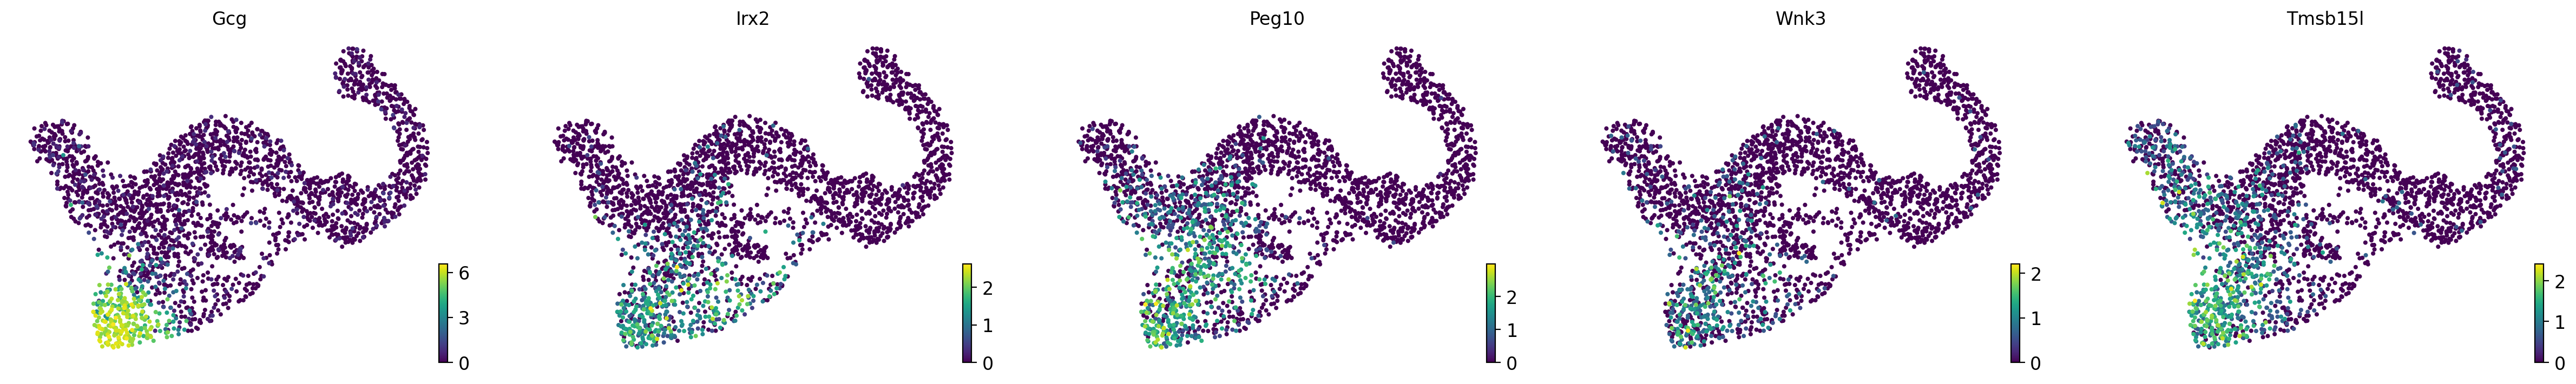

In [25]:
g.plot_lineage_drivers("Alpha", n_genes=5)

To find genes wich may be involved in fate choice early on, we could restrict the correlation to a subset of our clusters using the `cluster_key` and `clusters` parameters. 

To demonstrate yet another plotting function, we show how to visualize the distribution over fate choices using violin plots below:

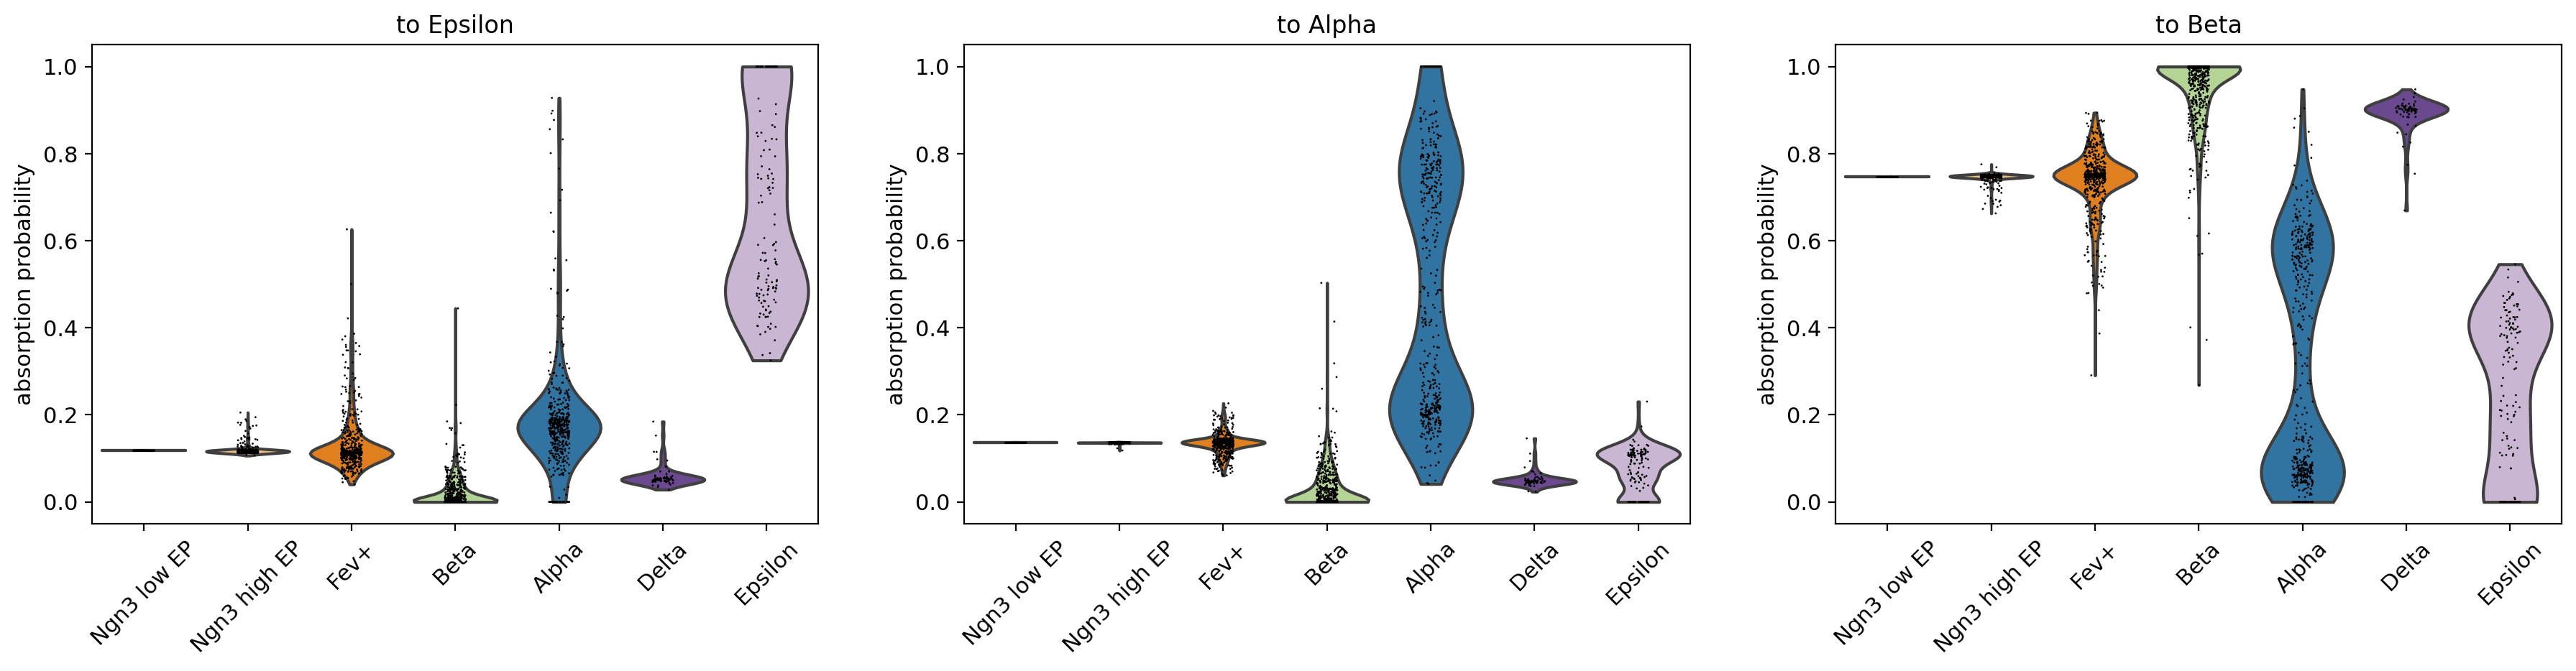

In [26]:
cr.pl.cluster_fates(adata, cluster_key='clusters', mode='violin')

We can see from this plot that at E15.5 in endocrine development, predominantly Beta cell are being produced. We can also see a bimodality in the Alpha cluster, which suggests that within that cluster, there is a subpopulation of cells which isn't yet commited. 

## Concluding remarks

- **initial states**: to compute initial states, simply repeat the above analysis passing `backward=True` to the kernel object when initializing it. The estimator object can be initialized as above with no changes needed.
- **Palantir kernel**: we could repeat the same analysis using the `PalantirKernel` we initialized by simply passing it to the `GPCCA` object as `g = cr.tl.estimators.GPCCA(pk)`. CellRank is build in a modular fashion - you can combine any `kernel` with any `estimator`. 
- **CFLARE estimator**: you can initialize a `CFLARE` object via `c = cr.tl.estimators.CFLARE(kenel)`. Most methods will have the same name, the two big differences are that CFLARE works with the eigendecomposition rather than the Schur decomposition and the way in which invariant subspaces are used to compute macrostates. 